## Part VII.2 - Train DeepAR model and publish to model store

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

In [3]:
# setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [4]:
import json
from time import gmtime, strftime

In [5]:
# configure model image and output path
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)
s3_output_path = s3_deepar_gold_dataset_path + "/output"
data_channels = {"train": "{}/train/".format(s3_deepar_gold_dataset_path), "test": "{}/val/".format(s3_deepar_gold_dataset_path)}

### Run training job with vanilla hyperparameters

In [4]:
# initialize estimator
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sess,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m5.xlarge",
    base_job_name="store-sales-forecasting-deepar",
    output_path=s3_output_path,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [35]:
# define vanilla hyperparameters
hyperparameters = {
    "time_freq": deepar_freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(deepar_context_length),
    "prediction_length": str(deepar_prediction_length),
}

In [36]:
# set hyperparameters to model
estimator.set_hyperparameters(**hyperparameters)

In [37]:
# train the model
history = estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: store-sales-forecasting-deepar-2024-10-01-23-40-35-127


2024-10-01 23:40:36 Starting - Starting the training job...
2024-10-01 23:40:51 Starting - Preparing the instances for training...
2024-10-01 23:41:28 Downloading - Downloading input data...
2024-10-01 23:41:48 Downloading - Downloading the training image..................
2024-10-01 23:45:05 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[10/01/2024 23:45:16 INFO 140471054513984] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patienc

In [ ]:
# initialize estimator
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    model_uri=''
    sagemaker_session=sess,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m5.xlarge",
    base_job_name="store-sales-forecasting-deepar",
    output_path=s3_output_path,
)

In [39]:
sm_transformer = estimator.transformer(1, "ml.m4.xlarge")

INFO:sagemaker:Creating model with name: store-sales-forecasting-deepar-2024-10-01-23-50-14-254


In [41]:
input_data_path = "{}/test/test.json".format(s3_deepar_gold_dataset_path)
sm_transformer.transform(input_data_path, split_type="Line")
sm_transformer.wait()

INFO:sagemaker:Creating transform job with name: store-sales-forecasting-deepar-2024-10-02-02-43-25-773


............................................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
Failed to set debug level to 20, using INFO
[10/02/2024 02:53:36 INFO 140273384396608] Estimated memory required per model 8.003568649291992MB.
[10/02/2024 02:53:36 INFO 140273384396608] Estimated available memory 14936.797550201416MB.
[10/02/2024 02:53:36 INFO 140273384396608] Estimated maximum number of workers for the available memory is 1866.
[10/02/2024 02:53:36 INFO 140273384396608] Using 4 workers
[10/02/2024 02:53:36 INFO 140273384396608] loading entry points
[10/02/2024 02:53:36 INFO 140273384396608] Prediction endpoint operating in batch mode
[10/02/2024 02:53:36 INFO 140273384396608] loaded request iterator applic

In [49]:
sm_transformer.output_path

's3://sagemaker-us-east-1-053585949834/store-sales-forecasting-deepar-2024-10-02-02-43-25-773'

### Hyperparameter Tuning

In [6]:
from sagemaker.tuner import HyperparameterTuner
from sagemaker.tuner import ContinuousParameter, IntegerParameter

In [5]:
# initialize estimator
tuned_estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sess,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m5.xlarge",
    base_job_name="store-sales-forecasting-deepar",
    output_path=s3_output_path,
    hyperparameters={"time_freq": deepar_freq, "prediction_length": str(deepar_prediction_length)},
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [6]:
hyperparameter_ranges = {    
    "epochs": IntegerParameter(50, 500),
    "context_length": IntegerParameter(3, 21),
    "mini_batch_size": IntegerParameter(32, 1028),
    "learning_rate": ContinuousParameter(0.00001, 0.1, scaling_type="Logarithmic"),
    "num_cells": IntegerParameter(30, 200)
}

In [9]:
# run hyperparameter tuner to search for optimal hyperparameters
training_job_name = "deepar-hyperparameter-tuning-job"
tuner = HyperparameterTuner(
    tuned_estimator,
    "test:RMSE",
    hyperparameter_ranges,
    [{"Name": "test:RMSE", "Regex": "test:RMSE: ([0-9\\.]+)"}],
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type="Minimize",
    base_tuning_job_name=training_job_name,
)
tuner.fit(inputs=data_channels, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
# capture the tuning job name for monitoring
#tuning_job_name  = "deepar-hyperparamete-241001-0503"
tuning_job_name = "deepar-hyperparamete-241004-2253"

In [8]:
# Monitor status of the tuning job
from pprint import pprint

tuning_job_result = sm.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

# print out full job
pprint(tuning_job_result)

Reminder: the tuning job has not been completed.
9 training jobs have completed
{'BestTrainingJob': {'CreationTime': datetime.datetime(2024, 10, 4, 23, 30, 6, tzinfo=tzlocal()),
                     'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'test:RMSE',
                                                                     'Value': 0.8663292527198792},
                     'ObjectiveStatus': 'Succeeded',
                     'TrainingEndTime': datetime.datetime(2024, 10, 5, 0, 33, 42, tzinfo=tzlocal()),
                     'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:053585949834:training-job/deepar-hyperparamete-241004-2253-006-9ae2eb62',
                     'TrainingJobName': 'deepar-hyperparamete-241004-2253-006-9ae2eb62',
                     'TrainingJobStatus': 'Completed',
                     'TrainingStartTime': datetime.datetime(2024, 10, 4, 23, 30, 12, tzinfo=tzlocal()),
                     'TunedHyperParameters': {'context_length': '13',
             

In [9]:
# Check best training run from tuning job
if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2024, 10, 4, 23, 30, 6, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'test:RMSE',
                                                 'Value': 0.8663292527198792},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 10, 5, 0, 33, 42, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:053585949834:training-job/deepar-hyperparamete-241004-2253-006-9ae2eb62',
 'TrainingJobName': 'deepar-hyperparamete-241004-2253-006-9ae2eb62',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 10, 4, 23, 30, 12, tzinfo=tzlocal()),
 'TunedHyperParameters': {'context_length': '13',
                          'epochs': '268',
                          'learning_rate': '0.004004413895551085',
                          'mini_batch_size': '955',
                          'num_cells': '53'}}


In [10]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    tuning_df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(tuning_df) > 0:
        tuning_df = tuning_df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(tuning_df))
        print({"lowest": min(tuning_df["FinalObjectiveValue"]), "highest": max(tuning_df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

tuning_df

Number of training jobs with valid objective: 8
{'lowest': 0.8663292527198792, 'highest': 1.0115693807601929}


context_length  epochs  learning_rate  mini_batch_size  num_cells  \
4            13.0   268.0       0.004004            955.0       53.0   
8            21.0   262.0       0.004297            337.0       52.0   
9            11.0    65.0       0.018959            508.0       63.0   
1            20.0   481.0       0.003953            159.0       54.0   
6            16.0   475.0       0.001018            791.0      124.0   
5             5.0   124.0       0.001257             92.0       30.0   
3            12.0   323.0       0.000045           1028.0       43.0   
7             3.0    93.0       0.001140            597.0      177.0   

                                 TrainingJobName TrainingJobStatus  \
4  deepar-hyperparamete-241004-2253-006-9ae2eb62         Completed   
8  deepar-hyperparamete-241004-2253-002-5a0cc56e         Completed   
9  deepar-hyperparamete-241004-2253-001-a1b5292a         Completed   
1  deepar-hyperparamete-241004-2253-009-67b87898         Completed   
6  deepar-hyperparamete-241004-2253-004-b53658a6         Completed   
5  deepar-hyperparamete-241004-2253-005-ed5c6ea5         Completed   
3  deepar-hyperparamete-241004-2253-007-043c01e4         Completed   
7  deepar-hyperparamete-241004-2253-003-255cf04c         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
4             0.866329 2024-10-04 23:30:12+00:00 2024-10-05 00:33:42+00:00   
8             0.899502 2024-10-04 22:54:29+00:00 2024-10-04 23:23:35+00:00   
9             0.900983 2024-10-04 22:54:32+00:00 2024-10-04 23:06:24+00:00   
1             0.903350 2024-10-05 02:03:01+00:00 2024-10-05 02:29:56+00:00   
6             0.910344 2024-10-04 23:26:10+00:00 2024-10-05 01:37:49+00:00   
5             0.953008 2024-10-04 23:26:12+00:00 2024-10-04 23:29:51+00:00   
3             0.961126 2024-10-05 00:42:07+00:00 2024-10-05 02:02:30+00:00   
7             1.011569 2024-10-04 23:08:36+00:00 2024-10-04 23:25:15+00:00   

   TrainingElapsedTimeSeconds  
4                      3810.0  
8                      1746.0  
9                       712.0  
1                      1615.0  
6                      7899.0  
5                       219.0  
3                      4823.0  
7                       999.0

In [21]:
from sagemaker.model import Model

In [27]:
# get model details from best training job
best_training_job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]
best_training_job = sm.describe_training_job(TrainingJobName=best_training_job_name)
best_model_path = best_training_job['ModelArtifacts']['S3ModelArtifacts']
best_training_job

{'TrainingJobName': 'deepar-hyperparamete-241004-2253-006-9ae2eb62',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:053585949834:training-job/deepar-hyperparamete-241004-2253-006-9ae2eb62',
 'TuningJobArn': 'arn:aws:sagemaker:us-east-1:053585949834:hyper-parameter-tuning-job/deepar-hyperparamete-241004-2253',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-053585949834/store-sales-forecasting/deepar/gold-dataset/output/deepar-hyperparamete-241004-2253-006-9ae2eb62/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'_tuning_objective_metric': 'test:RMSE',
  'context_length': '13',
  'epochs': '268',
  'learning_rate': '0.004004413895551085',
  'mini_batch_size': '955',
  'num_cells': '53',
  'prediction_length': '7',
  'time_freq': '1D'},
 'AlgorithmSpecification': {'TrainingImage': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'N

In [35]:
# save the best model
best_model_arn, best_model_name = save_trained_model(best_training_job_name)
best_model_name

'deepar-hyperparamete-241004-2253-006-9ae2eb62'

### Select Best Model Hyperparameters, train and save model

In [8]:
# get best hyperparameters from tuning job
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]
best_hyperparameters

{'context_length': '3',
 'epochs': '101',
 'learning_rate': '0.0006294407061415784',
 'mini_batch_size': '1024',
 'num_cells': '97'}

In [30]:
# define vanilla hyperparameters
best_hyperparameters = {
    "time_freq": deepar_freq,
    "epochs": "101",
    "num_cells": "97",
    "early_stopping_patience": "40",
    "mini_batch_size": "1024",
    "learning_rate": "0.0006294407061415784",
    "context_length": "3",
    "prediction_length": str(deepar_prediction_length),
}

In [31]:
# initialize estimator
best_estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sess,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m5.xlarge",
    base_job_name="store-sales-forecasting-deepar",
    output_path=s3_output_path,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [33]:
# set hyperparameters to model
best_estimator.set_hyperparameters(**best_hyperparameters)

In [34]:
# train the model
data_channels = {"train": "{}/train/".format(s3_deepar_gold_dataset_path), "test": "{}/val/".format(s3_deepar_gold_dataset_path)}
history = best_estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: store-sales-forecasting-deepar-2024-10-02-19-26-18-691


2024-10-02 19:26:21 Starting - Starting the training job...
2024-10-02 19:26:36 Starting - Preparing the instances for training...
2024-10-02 19:27:07 Downloading - Downloading input data...
2024-10-02 19:27:32 Downloading - Downloading the training image......
2024-10-02 19:28:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[10/02/2024 19:28:56 INFO 140504849958720] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embe

In [33]:
def save_trained_model(training_job_name):
    
    # save trained model
    info = sm.describe_training_job(TrainingJobName=training_job_name)
    model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
    model_name = training_job_name

    image = sagemaker.image_uris.retrieve(
        framework="forecasting-deepar", region=region, 
    )

    primary_container = {"Image": image, "ModelDataUrl": model_data}

    # Save our model to the Sagemaker Model Registry
    create_model_response = sm.create_model(
        ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
    )

    return create_model_response["ModelArn"], model_name

In [ ]:
# save trained model
info = sm.describe_training_job(TrainingJobName=best_estimator.latest_training_job.name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
model_name = best_estimator.latest_training_job.name

image = sagemaker.image_uris.retrieve(
    framework="forecasting-deepar", region=region, 
)

primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save our model to the Sagemaker Model Registry
create_model_response = sm.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

### Run batch transform to evaluate model on Test Data

In [37]:
# setup transform parameters
#best_model_name = "store-sales-forecasting-deepar-2024-10-02-19-26-18-691"
input_data_path = "{}/test/test.json".format(s3_deepar_gold_dataset_path)
output_data_path = "{}/output_test/".format(s3_deepar_gold_dataset_path)
#best_model_job_name = tuning_df.iloc[0]["TrainingJobName"]
#best_model_path = "{}/output/{}/output/model.tar.gz".format(s3_output_path, best_model_job_name)
#best_model_path

In [38]:
# initialize estimator
best_estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    model_name=best_model_name,
    sagemaker_session=sess,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m5.xlarge",
    base_job_name="store-sales-forecasting-deepar",
    output_path=output_data_path,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [39]:
# initialize transformer
best_transformer = best_estimator.transformer(
    1, 
    "ml.m4.xlarge", 
    model_name=best_model_name,
    assemble_with="Line",
    env={
        "DEEPAR_INFERENCE_CONFIG": json.dumps({
            "output_types": ["mean"],
        })
    }
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [40]:
# Run transform
best_transformer.transform(input_data_path, split_type='Line')
best_transformer.wait()

INFO:sagemaker:Creating transform job with name: store-sales-forecasting-deepar-2024-10-05-03-25-56-574


.............................................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Running custom environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
Failed to set debug level to 20, using INFO
[10/05/2024 03:36:09 INFO 140524050790208] Estimated memory required per model 9.267497062683105MB.
[10/05/2024 03:36:09 INFO 140524050790208] Estimated available memory 14945.265787124634MB.
Failed to set debug level to 20, using INFO
[10/05/2024 03:36:09 INFO 140524050790208] 

In [41]:
best_transformer_job_name = "store-sales-forecasting-deepar-2024-10-03-03-08-42-710"
best_transformer_output = best_transformer.output_path + "/test.json.out"
best_transformer_output

's3://sagemaker-us-east-1-053585949834/store-sales-forecasting-deepar-2024-10-05-03-25-56-574/test.json.out'

In [42]:
# copy job output locally for analysis
!aws s3 cp $best_transformer_output ./results/test-transform/
!aws s3 cp $input_data_path ./results/test-transform/

download: s3://sagemaker-us-east-1-053585949834/store-sales-forecasting-deepar-2024-10-05-03-25-56-574/test.json.out to results/test-transform/test.json.out
download: s3://sagemaker-us-east-1-053585949834/store-sales-forecasting/deepar/gold-dataset/test/test.json to results/test-transform/test.json


In [43]:
# helper function to load json
def load_json_by_line(file_path):
    results_raw = []
    with open(file_path) as f:
        for line in f:
            results_raw.append(json.loads(line))
    return results_raw

In [44]:
# load JSON output
inference_filename = "test.json"
results_local_filename = f"results/test-transform/{inference_filename}.out"
input_local_filename = f"results/test-transform/{inference_filename}"
transform_results = load_json_by_line(results_local_filename)
transform_input = load_json_by_line(input_local_filename)


In [45]:
# compile predictions with inputs
input_start_date = pd.to_datetime(transform_input[0]['start'])
predictions_available = False
predictions_data = []
for i, input in enumerate(transform_input):
    start_date = pd.to_datetime(input['start'])
    if(start_date > input_start_date):
        predictions_available = True
    store_nbr = int(input['cat'][0]) + 1
    targets = input['target']

    if(predictions_available):
        predictions = transform_results[i]['mean']
    else:
        predictions = np.negative(np.ones(len(targets)))
    
    for j in range(7):
        target = targets[j]
        target_date = start_date + pd.Timedelta(days=j)
        predictions_data.append([target_date, store_nbr, target, predictions[j]])

predictions_df = pd.DataFrame(columns=['date', 'store_nbr', 'true_sales', 'predicted_sales'], data=predictions_data)
predictions_df['date'] = pd.to_datetime(predictions_df['date'])
predictions_df


date  store_nbr  true_sales  predicted_sales
0    2017-02-27          1   -0.727627        -1.000000
1    2017-02-28          1    0.356655        -1.000000
2    2017-03-01          1   -0.478338        -1.000000
3    2017-03-02          1   -0.641618        -1.000000
4    2017-03-03          1   -0.755518        -1.000000
...         ...        ...         ...              ...
8311 2017-07-26         54    2.073559         0.662428
8312 2017-07-27         54    1.136342         1.100600
8313 2017-07-28         54    2.064418         0.772602
8314 2017-07-29         54    2.223392         0.517560
8315 2017-07-30         54    0.433368        -0.213936

[8316 rows x 4 columns]

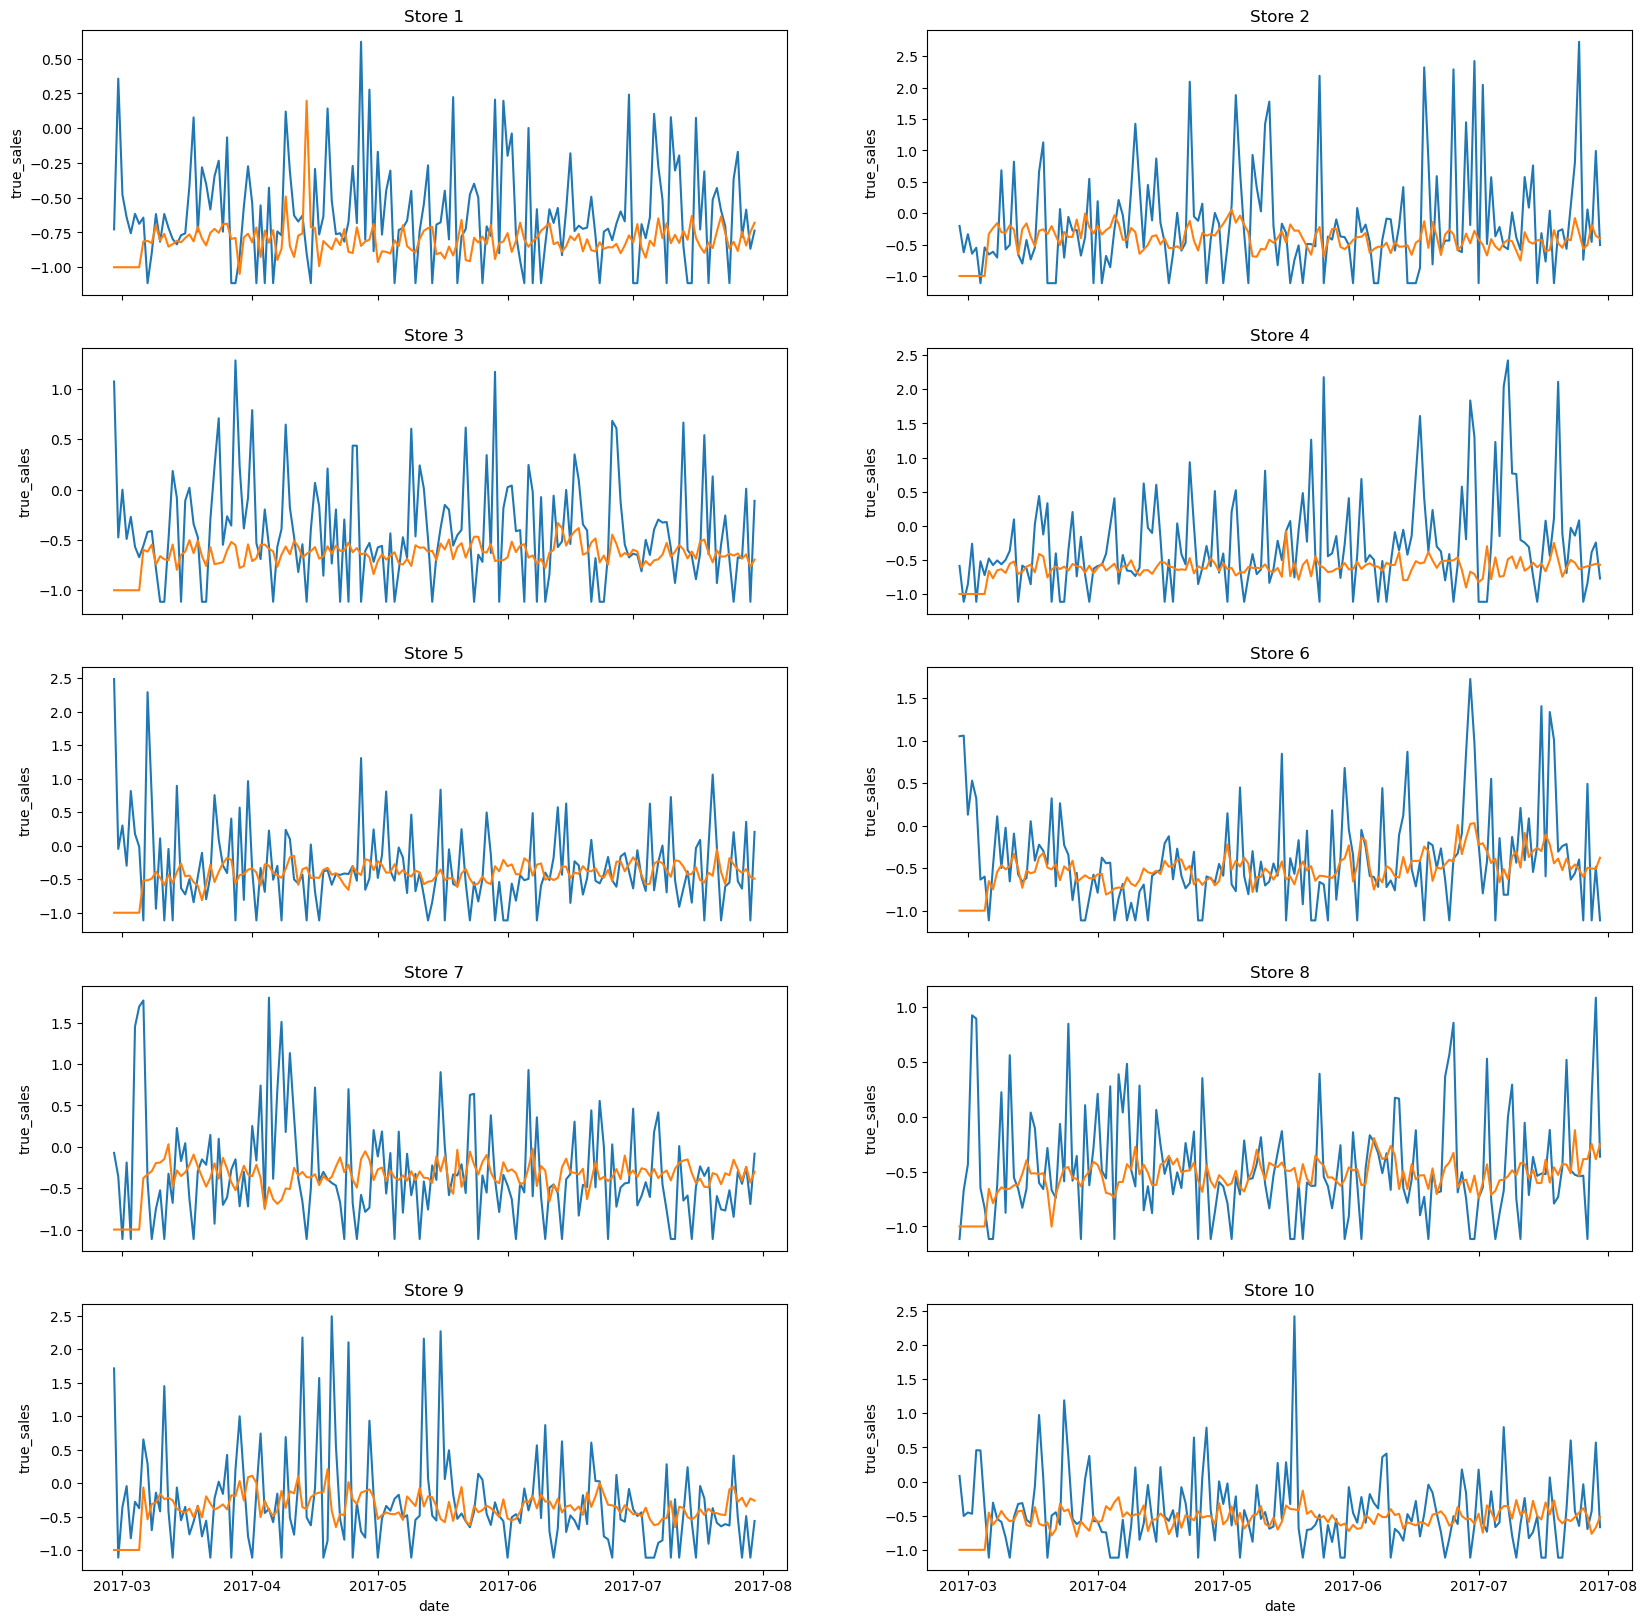

In [46]:
# visualize
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(1, 11):
    ax = axx[i-1]
    ax.set_title(f'Store {i}')
    store_plot = predictions_df[predictions_df['store_nbr'] == i]
    sns.lineplot(data=store_plot, x='date', y='true_sales', ax=ax)
    sns.lineplot(data=store_plot, x='date', y='predicted_sales', ax=ax)